https://www.thepythoncode.com/article/stock-price-prediction-in-python-using-tensorflow-2-and-keras

## Requirements

    !pip install requests_html
    !pip install wrapt --upgrade --ignore-installed
    !pip install tensorflow
    !pip3 install pandas numpy matplotlib yahoo_fin sklearn 

In [ ]:
# %load TensorFlow.py
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# from functions import get_finance_data

# set seed, so we can get the same results after rerunning several times
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [ ]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

In [ ]:
def load_data(df, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low'], target_col='adjclose'):
    """
    Get df scaling, shuffling, normalizing and splitting.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the dataset (both training & testing), default is True
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        split_by_date (bool): whether we split the dataset into training/testing by date, setting it 
            to False will split datasets in a random way
        test_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """

    result = {}
    result['df'] = df.copy()
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    if "date" not in df.columns:
        df["date"] = df.index
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    result['last_sequence'] = last_sequence
    
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    
    # convert to numpy arrays
    X, y = np.array(X), np.array(y)
    
    if split_by_date:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)
    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    return result


#%%

def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

#%%

# df = get_finance_data('VALE3.SA',period='1y')
# df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

ticker = "VALE3.SA"
df = si.get_data(ticker, start_date='20200701', end_date='20201229')
df = df[['open', 'high', 'low', 'close', 'adjclose', 'volume']]

#%%

In [8]:
import time

N_STEPS = 50
LOOKUP_STEP = 15
# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
TEST_SIZE = 0.2
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
date_now = time.strftime("%Y-%m-%d")
N_LAYERS = 2
CELL = LSTM
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False
### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 50#0


# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [9]:
#%%
# load the data
data = load_data(df, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS, target_col='adjclose')

#%%
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")
    
# save the dataframe
# ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# data["df"].to_csv(ticker_data_filename)
#%%
# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

In [10]:
import time
start = time.time()
print('Inicio:', time.ctime(start))

# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=0, 
                    use_multiprocessing=True)

Inicio: Fri Jan  1 15:52:50 2021

Epoch 00001: val_loss improved from inf to 0.05848, saving model to results\2021-01-01_VALE3.SA-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5

Epoch 00002: val_loss improved from 0.05848 to 0.03257, saving model to results\2021-01-01_VALE3.SA-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5

Epoch 00003: val_loss did not improve from 0.03257

Epoch 00004: val_loss improved from 0.03257 to 0.01433, saving model to results\2021-01-01_VALE3.SA-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5

Epoch 00005: val_loss did not improve from 0.01433

Epoch 00006: val_loss did not improve from 0.01433

Epoch 00007: val_loss improved from 0.01433 to 0.01414, saving model to results\2021-01-01_VALE3.SA-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5

Epoch 00008: val_loss improved from 0.01414 to 0.01322, saving model to results\2021-01-01_VALE3.SA-sh-1-sc-1-sbd-

Fim: Fri Jan  1 15:53:54 2021
Tempo total 1.07 min
Future price after 15 days is 110.04$
huber_loss loss: 0.006183004006743431
Mean Absolute Error: 55.28856845654398
Accuracy score: 0.9166666666666666
Total buy profit: 64.92063903808594
Total sell profit: -2.1915321350097656
Total profit: 62.72910690307617
Profit per trade: 5.227425575256348


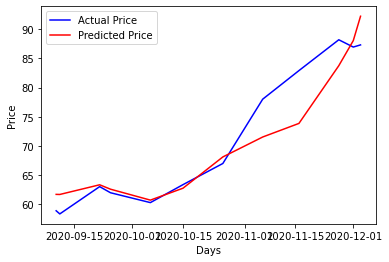

                 open       high        low      close   adjclose    volume  \
2020-09-22  58.139999  58.279999  57.150002  57.810001  57.810001  23996200   
2020-09-25  58.349998  59.450001  58.200001  59.250000  59.250000  27582200   
2020-10-06  60.009998  60.279999  58.209999  58.619999  58.619999  21951600   
2020-10-15  62.410000  62.860001  61.980000  62.470001  62.470001  16309700   
2020-10-26  62.900002  63.450001  62.009998  62.500000  62.500000  18250900   
2020-11-06  62.380001  63.959999  62.340000  63.340000  63.340000  21039200   
2020-11-16  63.500000  65.339996  62.970001  64.919998  64.919998  91477900   
2020-11-27  77.000000  78.779999  76.769997  78.199997  78.199997  35777100   
2020-12-01  79.830002  81.500000  79.250000  81.250000  81.250000  61441200   
2020-12-03  81.000000  81.050003  78.610001  78.959999  78.959999  35158600   

            adjclose_15  true_adjclose_15  buy_profit  sell_profit  
2020-09-22    63.316311         63.000000    5.506310        

In [11]:
end = time.time()
print('Fim:', time.ctime(end))
print('Tempo total', round((end - start)/60, 2), 'min')


# In[53]:




def plot_graph(test_df):
    """
    This function plots true close price along with predicted close price
    with blue and red colors respectively
    """
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()


# In[54]:


def get_final_df(model, data):
    """
    This function takes the `model` and `data` dict to 
    construct a final dataframe that includes the features along 
    with true and predicted prices of the testing dataset
    """
    # if predicted future price is higher than the current, then calculate the true future price minus the current price, to get the buy profit
    buy_profit  = lambda current, true_future, pred_future: true_future - current if pred_future > current else 0
    # if the predicted future price is lower than the current price, then subtract the true future price from the current price
    sell_profit = lambda current, true_future, pred_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"adjclose_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_adjclose_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df


# In[55]:


def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price


# In[56]:


# load optimal model weights from results folder
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)


# In[38]:


# evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae


# In[223]:

final_df = get_final_df(model, data)
future_price = predict(model, data)

# In[145]:

    # we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)


# In[219]:

# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)


# In[147]:

    # plot true/pred prices graph
plot_graph(final_df)


# In[101]:


print(final_df.tail(10))
# save the final dataframe to csv-results folder
csv_results_folder = "csv-results"
if not os.path.isdir(csv_results_folder):
    os.mkdir(csv_results_folder)
csv_filename = os.path.join(csv_results_folder, model_name + ".csv")
final_df.to_csv(csv_filename)